# Dimensionality Reduction 
**Adapted from Hands-On Machine Learning with Scikit-Learn and TensorFlow by Aurélien Géron**

https://github.com/ageron/handson-ml

-  Reducing dimensionality to speed up training when there are many features (e.g. thousands or millions) for each training instance.
- Reducing dimensionality does reduce information.
- It is useful for data visualization.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# to make this notebook's output stable across runs
np.random.seed(42)

Build a 3D dataset:

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## Projection Methods

### PCA 

- Identifies the hyperplane that lies closest to the data.
- Then, it projects the data onto it.

Here we reduced the dataset to two dimensions:

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [4]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

Running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped.

Recover the 3D points projected on the plane (PCA 2D subspace):

In [5]:
X3_inv = pca.inverse_transform(X2D)

The `PCA` object gives access to the principal components that it computed:

In [6]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [7]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

The first dimension explains 84.2% of the variance, while the second explains 14.6%.

By projecting down to 2D, we lost about 1.1% of the variance:

In [8]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

### MNIST Compression

After dimensionality reduction, the training set takes up less space. Here we will apply PCA to MNISt dataset while preserving 95% of the variance. Each instance will have over 150 feature instead of the original 784 reducing the size to less that 20% of the original:

In [9]:
# conda install -c conda-forge tensorflow 
# conda install -c conda-forge keras
from six.moves import urllib
import tensorflow as tf

mnist = tf.keras.datasets.mnist

(X_train, y_train),(X_test, y_test)= mnist.load_data()

In [10]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784) 

In [11]:
pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [12]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [13]:
pca.n_components_

154

In [14]:
np.sum(pca.explained_variance_ratio_)

0.9501960192613034

The `inverse_transform()` method can be used to decompresse the data back to 784 dimensions:

In [15]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

Plot original vs reduced data:

In [16]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

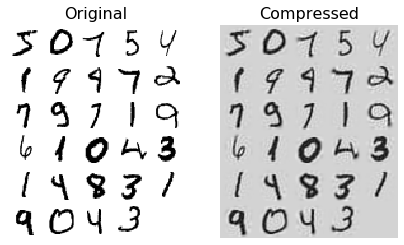

In [17]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16);

There is some image quality loss after reduction but but the digits are mostly intact.

`IncrementalPCA` is typically used as a replacement for PCA when the dataset to be decomposed is too large to fit in memory. You can split the training set into mini-batches and feed the algorithm one mini-batch at a time. 

It is able to find a similar projection of the data to PCA, while only processing a few samples at a time.

In [18]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100 
inc_pca = IncrementalPCA(n_components = 154)

for X_batch in np.array_split(X_train, n_batches):
    print('.', end='')
    inc_pca.partial_fit(X_train)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [19]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

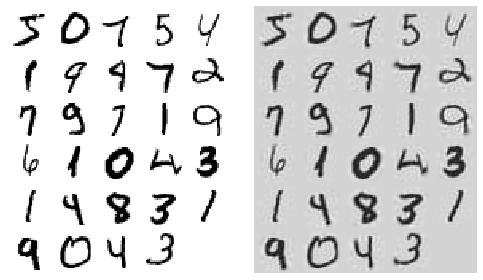

In [20]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

Again, there is some image quality loss after reduction but but the digits are mostly intact.

In [23]:
X_reduced_inc_pca = X_reduced

Compare the results of transforming MNIST using regular PCA and incremental PCA. First, the means are equal:

In [24]:
np.allclose(pca.mean_, inc_pca.mean_)

True

But the results are not exactly identical.`IncrementalPCA` gives a very good approximate solution, but it's not perfect:

In [26]:
np.allclose(X_reduced, X_reduced_inc_pca)

True

## Kernel PCA

- To perform complex nonlinear projections for dimensionality reduction.
- **Kernel trick**: technique that implicitly maps instances into a very high-dimensional space to perform complex nonlinear projections for dimensionality reduction.
- Good at preserving clusters of instances after projection or even unrolling datasets.

In [39]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

Plot the swiss roll:

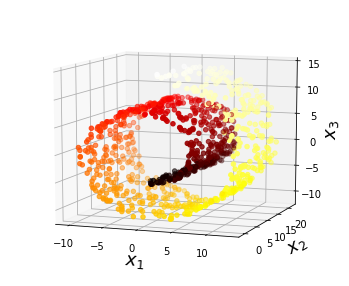

In [40]:
from mpl_toolkits.mplot3d import proj3d

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6]);

In [41]:
y = t > 6.9

In [42]:
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid = GridSearchCV(clf, param_grid, cv=3)
grid.fit(X, y)

/home/mabeigier/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mabeigier/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mabeigier/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mabeigier/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mabeigier/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be ch

/home/mabeigier/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mabeigier/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mabeigier/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mabeigier/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mabeigier/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be ch

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=None,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRe...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kpca__gamma': array([0.03   , 0.03222, 0.03444, 0.03667, 0.03889, 0.04111, 0.04333,
       0.04556, 0.04778, 0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [43]:
print(grid.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


## Example: Eigenfaces

In [46]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


PCA contains a randomized method to approximate the first $N$ principal components much more quickly than the standard ``PCA`` estimator, and thus is very useful for high-dimensional data (here, a dimensionality of nearly 3,000).

In [47]:
from sklearn.decomposition import PCA

pca = PCA(150, svd_solver='randomized')
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

Visualize the images associated with the first several principal components (known as "eigenvectors," so these types of images are often called "eigenfaces")

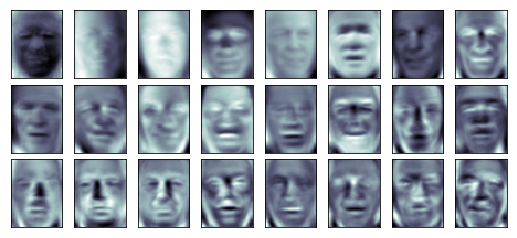

In [48]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

The first few eigenfaces (from the top left) seem to be associated with the angle of lighting on the face, and later principal vectors seem to be picking out certain features, such as eyes, noses, and lips.

Plot the cumulative variance of these components to see how much of the data information the projection is preserving:

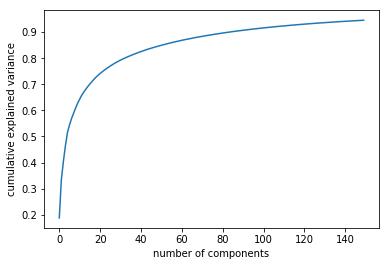

In [49]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

150 components account for just over 90% of the variance so using these 150 components, we would recover most of the essential characteristics of the data.

Compare the input images with the images reconstructed from these 150 components:

In [50]:
# compute the components and projected faces
pca = PCA(150, svd_solver='randomized').fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

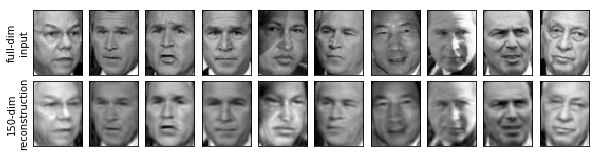

In [51]:
# plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

The top row here shows the input images, while the bottom row shows the reconstruction of the images from just 150 of the ~3,000 initial features. PCA reduces the dimensionality of the data by nearly a factor of 20, the projected images contain enough information that we might, by eye, recognize the individuals in the image.

## Manifold Learning

PCA is flexible, fast, and easily interpretable, but it does not perform so well when there are nonlinear relationships within the data.

**Manifold learning**: a class of unsupervised estimators that seeks to describe datasets as low-dimensional manifolds embedded in high-dimensional spaces.

Manifold methods: 
- **LLE**: locally linear embedding
- **IsoMap**: isometric mapping

Generate some 2D data:

In [55]:
def make_hello(N=1000, rseed=42):
    # make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

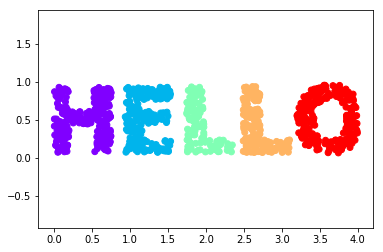

In [56]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

## Nonlinear Manifolds: Locally Linear Embedding

Preserve only distances between nearby points.

**LLE**: preserves only the distances between neighboring points.

**Modified LLE** does better than other flavors of the algorithm at recovering well-defined manifolds with very little distortion.

Create a 3D 'Hello' chart: 

In [57]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

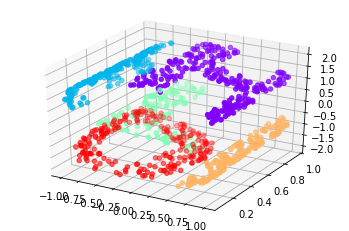

In [58]:
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

Now we will use the modified LLE algorithm to recover the embedded two-dimensional manifold. 

In general, modified LLE does better than other flavors of the algorithm at recovering well-defined manifolds with very little distortion:

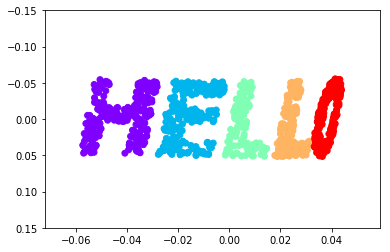

In [59]:
from sklearn.manifold import LocallyLinearEmbedding

model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                              eigen_solver='dense')
out = model.fit_transform(XS)
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);